# Men's Olympic 100m winning times
This notebook illustrates the implementation of least squares to find the unknown parameters of a linear regressor given the training data

In [1]:
using Plots
# using LinearAlgebra
using DataFrames
using StatsPlots
using CSV

In [2]:
data_folder = "./data/"

"./data/"

In [3]:
# 1- Data loading
file_path = joinpath(data_folder, "olympics_100m.csv")  # Construct the full file path

# Read the CSV file using DataFrames
ds = DataFrame(CSV.File(file_path))

# Splitting training/test
n = size(ds, 1)
training = ds[1:n-2, :]
testing = ds[n-1:end, :]

# Let's use the notation from the lecture
X = training[:, "Year"]
y = training[:, "Time"]
X = reshape(X, length(X), 1);  # Reshape X to a 2D array

In [4]:
using PrettyTables

In [5]:
 header = (
      ["Year", "Time"]
    , ["[yyyy]", "[Int64]"]
);

In [6]:
pretty_table(first(ds, 10), backend=Val(:html), header = header, standalone=true)

Year,Time
[yyyy],[Int64]
1896,12.0
1900,11.0
1904,11.0
1908,10.8
1912,10.8
1920,10.8
1924,10.6
1928,10.8
1932,10.32


In [7]:
function polynomial_features(X, degree)
    n_samples, n_features = size(X)
    
    # Initialize an empty matrix for the polynomial features
    poly_features = ones(n_samples, 1)
    
    # Generate polynomial features up to the specified degree
    for d = 1:degree
        for feature = 1:n_features
            poly_features = hcat(poly_features, X[:, feature].^d)
        end
    end

    return poly_features
end

polynomial_features (generic function with 1 method)

In [8]:
degree = 1       # Specify the degree of the polynomial

# Create polynomial features
X = polynomial_features(X, degree)

# Display X's type and its 1st two columns
@show typeof(X), X[1:2,:];

(typeof(X), X[1:2, :]) = (Matrix{Float64}, [1.0 1896.0; 1.0 1900.0])


In [9]:
include("ops.jl")

findmax (generic function with 10 methods)

Now, let's compute the weights using the least squares method:

$\mathbf{\hat{w}}=(\mathbf{X}^{T}\mathbf{X})^{-1}\mathbf{X}^{T}\mathbf{y}$

In [10]:
ŵ = ((X)ᵀ * X)⁻¹ * (X)ᵀ * y 
println("Weights: ", ŵ)

Weights: [35.77145619588415, -0.0130037735192905]


Let's estimate the mean squared error (MSE) and the residual sum-of-squares (RSS):

In [11]:
# number of samples
N = nrow(training) 

# Calculate ŷ
ŷ = ∑( X * ŵ, dims=2 )

# Calculate RSS
RSS = ∑((y .- ŷ) .^ 2)

# Calculate MSE
MSE = (N)⁻¹ * RSS

# Print RSS and MSE
println("RSS: ", RSS, "\nMSE: ", MSE)

RSS: 1.304203366605224
MSE: 0.04830382839278607


Now, let's predict the times of 2016 and 2020 

*Note:* Olympics were held in 2021.

In [12]:
# Extract and preprocess the test data
X_test = testing[:, "Year"]
y_test = testing[:, "Time"]
X_test = reshape(X_test, length(X_test), 1) # 
@show X_test;

degree = 1       # Specify the degree of the polynomial

# Create polynomial features
X_test = polynomial_features(X_test, degree) # Apply the same PolynomialFeatures transformation

# Display the result
@show X_test;

X_test = [2016; 2020;;]
X_test = [1.0 2016.0; 1.0 2020.0]


In [13]:
# number of samples
N = nrow(testing) 

# Calculate ŷ_test
ŷ_test = ∑( X_test * ŵ, dims=2 )

# Calculate RSS
RSS = ∑((y_test .- ŷ_test) .^ 2)

# Calculate MSE for the test data
MSE_test = (N)⁻¹ * RSS

0.07615366356347843

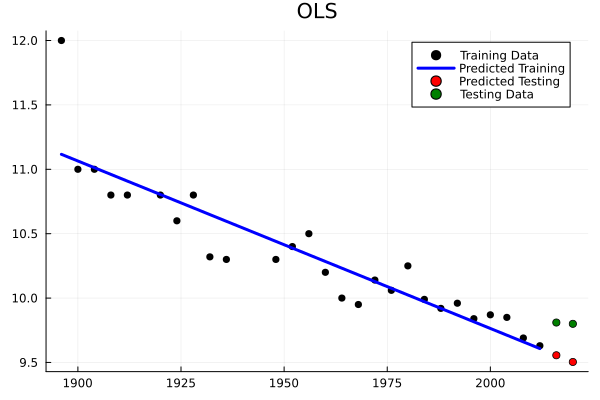

In [14]:
using Plots

# Set the size of the figure
default(size=(600, 400))

# Scatter plot for training data
scatter(X[:, 2], y, color="black", label="Training Data", title="OLS")

# Line plot for the predicted values on training data
plot!(X[:, 2], ŷ, color="blue", linewidth=3, label="Predicted Training")

# Scatter plot for testing data and predictions
scatter!(X_test[:, 2], ŷ_test, color="red", label="Predicted Testing")
scatter!(X_test[:, 2], y_test, color="green", label="Testing Data")

# Display the plot
display(plot!())

In [15]:
# Print MSE for Test
println("MSE: ", MSE_test)

MSE: 0.07615366356347843


In [16]:
println("Predicted times [2016, 2020]: ", ŷ_test)
println("Real times [2016, 2020]: ", y_test)

Predicted times [2016, 2020]: [9.555848780994502, 9.503833686917341]
Real times [2016, 2020]: [9.81, 9.8]


## An alternative solution
The previous solution might not be the best, as it can be computationally unstable.

Here, we illustrate an alternative method and we also estimate $\sigma^2$

In [17]:
#Let's get the data from scratch again to play on the safe side
#Splitting traing/test
X = training[:, "Year"]
y = training[:, "Time"]
X = reshape(X, length(X), 1)  # Reshape X to a 2D array

degree = 1       # Specify the degree of the polynomial

# Create polynomial features
X = polynomial_features(X, degree);

In [20]:
using LinearAlgebra

In [34]:
function MLE(X, y)
    
    N = size(X, 1)
    
    # An alternative and more efficient way to compute: using a linear solver to solve the eq Ax = b
    # w = linalg.solve(X_t_X, X_T_y) in Python
    # but in Julia, the backslash operator (\) is used for solving linear systems. 
    # as a result the LS calculation is equivalent to the MLE
    # except the function returns the σ² (variance) calculation
    ŵ = ((X)ᵀ*X)⁻¹ * (X)ᵀ*y  # also equivalent to ŵ = (X)ᵀ*X \ (X)ᵀ*y
    
    # Solving for sigma
    ŷ = ∑(X .* (ŵ)ᵀ, dims=2)
    ϵ = y .- ŷ
    σ² = 1 / N * ϵ ⋅ ϵ

    return ŵ, σ²
end

MLE (generic function with 1 method)

In [35]:
ŵ, σ² = MLE(X,y)
println("Weights: ", ŵ, " σ²: ", σ²)

Weights: [35.77145619588415, -0.0130037735192905] σ²: 0.04830382839278596


In [36]:
rounding = 15 # number of decimal digits
round(MSE, digits=rounding) == round(σ², digits=rounding)

true

# References

- [ ] [linear regression in Julia](https://www.machinelearningplus.com/linear-regression-in-julia/)